# Xarray with Dask Arrays

In this notebook we show how to apply xarray operations on Dask DataArray objects.

- Open a dataset
- Use standard xarray operations
- Persist data in memory
- Custom workflows and automatic parallelisation

The following material uses Coupled Model Intercomparison Project (CMIP6) collections. The CMIP6 terms of use are found [here](https://pcmdi.llnl.gov/CMIP6/TermsOfUse/TermsOfUse6-1.html). For more information on the collection, please see the [NCI Data Catalogue]( https://geonetwork.nci.org.au/geonetwork/srv/eng/catalog.search#/metadata/f6600_2266_8675_3563).

-----

- Authors: NCI Virtual Research Environment Team
- Keywords: CMIP6, xarray, dask
- Create Date: 2020-May
---

In [3]:
%matplotlib inline

import dask
import xarray as xr

### Start Dask Client for Dashboard

Choose from the following two options to create a client:

In [1]:
# If you run this notebook on your local computer or NCI's VDI instance, you can create cluster
from dask.distributed import Client
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:43391' processes=4 threads=8, memory=33.56 GB>


In [ ]:
from dask.distributed import Client, LocalCluster
client = Client(scheduler_file='scheduler.json')
print(client)

<div class="alert alert-info">
<b>Warning: Please make sure you specify the correct path to the schedular.json file within your environment.</b>  
</div>

Starting the Dask Client will provide a dashboard which is useful to gain insight into the computation. The link to the dashboard will become visible when you create the Client. We recommend having the Client open on one side of your screen and your notebook open on the other side, which will be useful for learning purposes.

### Open a dataset

Xarray is an open source project and Python package that extends the labeled data functionality of Pandas to N-dimensional array-like datasets. It shares a similar API to NumPy and Pandas and supports both Dask and NumPy arrays under the hood. 

By specifying the chunk shape, xarray will automatically create Dask arrays for each data variable in the `Dataset`. In xarray, `Datasets` are dict-like containers of labeled arrays, analogous to the `pandas.DataFrame`. Note that we're taking advantage of Xarray's dimension labels when specifying chunk shapes.

In [4]:
filename = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/6hrLev/ps/gn/latest/*.nc'
ds = xr.open_mfdataset(filename,combine='nested', concat_dim='time',chunks={'lat': 144, 'lon': 92, 'time': -1})
ds = ds.sel(time=slice('1950','1951'))
ds

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 144, lon: 192, time: 2919)
Coordinates:
  * lat       (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon       (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * time      (time) datetime64[ns] 1950-01-01T06:00:00 ... 1951-12-31T18:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (time, lat, bnds) float64 dask.array<chunksize=(2919, 144, 2), meta=np.ndarray>
    lon_bnds  (time, lon, bnds) float64 dask.array<chunksize=(2919, 92, 2), meta=np.ndarray>
    ps        (time, lat, lon) float32 dask.array<chunksize=(2919, 144, 92), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-08T06:00:27Z
    data_specs_version:     01.00.30
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              6hrPt
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.CSIRO-ARCCSS...
    grid:                   native atmosphere N96 grid (144x192 latxlon)
    grid_label:             gn
    history:                2019-11-08T06:00:27Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institution_id:         CSIRO-ARCCSS
    mip_era:                CMIP6
    nominal_resolution:     250 km
    notes:                  Exp: CM2-historical; Local ID: bj594; Variable: p...
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       ACCESS-CM2
    parent_time_units:      days since 0950-01-01
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    run_variant:            forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2,...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    source_id:              ACCESS-CM2
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               6hrLev
    table_info:             Creation Date:(30 April 2019) MD5:e14f55f257cceaf...
    title:                  ACCESS-CM2 output prepared for CMIP6
    variable_id:            ps
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/d28c06ba-e284-436a-84fe-ae8d4520879f
    license:                CMIP6 model data produced by CSIRO is licensed un...

Quickly inspecting the `Dataset` above, we'll note that this `Dataset` has four _dimensions_ akin to axes in NumPy (`lat`, `lon`, and `time`), four _coordinate variables_ akin to `pandas.Index` objects (also named `lat`, `lon`, and `time`), and one data variable (`ps`). Xarray also holds Dataset specific metadata as _attributes_.

In [5]:
da = ds['ps']
da

<xarray.DataArray 'ps' (time: 2919, lat: 144, lon: 192)>
dask.array<getitem, shape=(2919, 144, 192), dtype=float32, chunksize=(2919, 144, 92), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * time     (time) datetime64[ns] 1950-01-01T06:00:00 ... 1951-12-31T18:00:00
Attributes:
    standard_name:  surface_air_pressure
    long_name:      Surface Air Pressure
    comment:        surface pressure (not mean sea-level pressure), 2-D field...
    units:          Pa
    cell_methods:   area: mean time: point
    cell_measures:  area: areacella
    history:        2019-11-08T06:00:23Z altered by CMOR: replaced missing va...

Each data variable in xarray is called a `DataArray`. These are the fundemental labeled array object in xarray. Much like the `Dataset`, `DataArrays` also have _dimensions_ and _coordinates_ that support many of its label-based opperations.

In [6]:
da.data

dask.array<getitem, shape=(2919, 144, 192), dtype=float32, chunksize=(2919, 144, 92), chunktype=numpy.ndarray>

Accessing the underlying array of data is done via the `data` property. Here we can see that we have a Dask array. If this array were to be backed by a NumPy array, this property would point to the actual values in the array.

### Use Standard Xarray Operations

In almost all cases, operations using xarray objects are identical regardless of whether the underlying data is stored as a Dask array or a NumPy array.

In [7]:
da2 = da.groupby('time.month').mean('time')
da3 = da.groupby('time.month') - da2
da3

,Array,Chunk
Bytes,322.82 MB,6.57 MB
Shape,"(2919, 144, 192)","(124, 144, 92)"
Count,412 Tasks,72 Chunks
Type,float32,numpy.ndarray


In [8]:
da3.data

,Array,Chunk
Bytes,322.82 MB,6.57 MB
Shape,"(2919, 144, 192)","(124, 144, 92)"
Count,412 Tasks,72 Chunks
Type,float32,numpy.ndarray


Call .compute() or .load() when you want your result as a xarray.DataArray with data stored as NumPy arrays.

If you started Client() above then you may want to watch the status page during computation.

In [9]:
computed_da = da3.load()
type(computed_da.data)

numpy.ndarray

In [10]:
computed_da

<xarray.DataArray 'ps' (time: 2919, lat: 144, lon: 192)>
array([[[-833.71094, -833.4453 , -833.64844, ..., -836.58594,
         -836.3828 , -836.9375 ],
        [-868.46094, -869.39844, -870.28125, ..., -864.4531 ,
         -865.34375, -865.90625],
        [-898.8047 , -898.91406, -898.3672 , ..., -899.8203 ,
         -899.59375, -899.25   ],
        ...,
        [ 414.6953 ,  413.3828 ,  411.97656, ...,  417.79688,
          416.60938,  415.57812],
        [ 445.97656,  445.60938,  445.1953 , ...,  446.26562,
          446.2422 ,  446.1875 ],
        [ 457.79688,  457.9375 ,  458.01562, ...,  457.09375,
          457.35938,  457.66406]],

       [[-788.10156, -787.5703 , -787.46094, ..., -792.0703 ,
         -791.46094, -791.41406],
        [-807.4922 , -807.2344 , -806.8672 , ..., -806.1406 ,
         -805.9922 , -805.7656 ],
        [-833.875  , -831.4219 , -827.9375 , ..., -839.71875,
         -837.89844, -835.8281 ],
...
        [2244.8047 , 2249.5234 , 2254.5547 , ..., 2232.9844 ,
         2236.6328 , 2240.6406 ],
        [2454.1094 , 2457.3672 , 2460.7344 , ..., 2444.9297 ,
         2447.9062 , 2450.9062 ],
        [2579.4844 , 2580.5938 , 2581.7031 , ..., 2576.4844 ,
         2577.3906 , 2578.4531 ]],

       [[1101.3359 , 1099.25   , 1098.6016 , ..., 1101.5938 ,
         1101.8125 , 1102.1484 ],
        [1150.6484 , 1148.2031 , 1145.8828 , ..., 1157.0078 ,
         1154.5312 , 1152.3672 ],
        [1157.4688 , 1152.9688 , 1148.6172 , ..., 1172.4453 ,
         1166.8594 , 1161.8203 ],
        ...,
        [2487.125  , 2488.1094 , 2489.2734 , ..., 2485.3516 ,
         2485.8438 , 2486.5078 ],
        [2660.3984 , 2661.6484 , 2662.9297 , ..., 2656.7266 ,
         2657.9531 , 2659.125  ],
        [2752.4297 , 2753.1094 , 2753.7812 , ..., 2750.4922 ,
         2751.086  , 2751.7812 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * time     (time) datetime64[ns] 1950-01-01T06:00:00 ... 1951-12-31T18:00:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12

### Persist data in memory

If you have the available RAM for your dataset then you can persist data in memory.  

This allows future computations to be much faster.

In [11]:
da = da.persist()

### Time Series Operations

We want datetime index time-series operations to work efficiently. Here we demo the use of xarray's resample method:

In [25]:
da.resample(time='1D').mean('time')

,Array,Chunk
Bytes,80.73 MB,52.99 kB
Shape,"(730, 144, 192)","(1, 144, 92)"
Count,8763 Tasks,2190 Chunks
Type,float32,numpy.ndarray


Rolling window operations:

In [13]:
da_smooth = da.rolling(time=30).mean().persist()
da_smooth

<xarray.DataArray (time: 2919, lat: 144, lon: 192)>
dask.array<where, shape=(2919, 144, 192), dtype=float32, chunksize=(2904, 144, 92), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * time     (time) datetime64[ns] 1950-01-01T06:00:00 ... 1951-12-31T18:00:00

Since xarray stores each of its coordinate variables in memory, slicing by label is trivial and entirely lazy.

In [14]:
%time da.sel(time='1950-01-01T18:00:00')

CPU times: user 5.16 ms, sys: 1.05 ms, total: 6.21 ms
Wall time: 5.95 ms


<xarray.DataArray 'ps' (lat: 144, lon: 192)>
dask.array<getitem, shape=(144, 192), dtype=float32, chunksize=(144, 92), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    time     datetime64[ns] 1950-01-01T18:00:00
Attributes:
    standard_name:  surface_air_pressure
    long_name:      Surface Air Pressure
    comment:        surface pressure (not mean sea-level pressure), 2-D field...
    units:          Pa
    cell_methods:   area: mean time: point
    cell_measures:  area: areacella
    history:        2019-11-08T06:00:23Z altered by CMOR: replaced missing va...

In [15]:
%time da.sel(time='1950-01-01T18:00:00').load()

CPU times: user 50.9 ms, sys: 14 ms, total: 64.9 ms
Wall time: 660 ms


<xarray.DataArray 'ps' (lat: 144, lon: 192)>
array([[ 68996.75 ,  68968.57 ,  68952.195, ...,  69236.875,  69219.5  ,
         69200.625],
       [ 69038.47 ,  69027.5  ,  69019.69 , ...,  68927.02 ,  68927.34 ,
         68925.39 ],
       [ 69702.08 ,  69628.38 ,  69553.98 , ...,  69920.69 ,  69840.05 ,
         69760.555],
       ...,
       [102282.68 , 102285.52 , 102288.195, ..., 102273.43 , 102276.62 ,
        102279.695],
       [102390.516, 102392.375, 102394.22 , ..., 102384.99 , 102386.82 ,
        102388.664],
       [102509.04 , 102509.8  , 102510.57 , ..., 102506.875, 102507.58 ,
        102508.3  ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    time     datetime64[ns] 1950-01-01T18:00:00
Attributes:
    standard_name:  surface_air_pressure
    long_name:      Surface Air Pressure
    comment:        surface pressure (not mean sea-level pressure), 2-D field...
    units:          Pa
    cell_methods:   area: mean time: point
    cell_measures:  area: areacella
    history:        2019-11-08T06:00:23Z altered by CMOR: replaced missing va...

### Custom workflows and automatic parallelisation
Almost all of xarray’s built-in operations work on Dask arrays. If you want to use a function that isn’t wrapped by xarray, one option is to extract Dask arrays from xarray objects (.data) and use Dask directly.

Another option is to use xarray’s `apply_ufunc()` function, which can automate embarrassingly parallel “map” type operations where a function written for processing NumPy arrays should be repeatedly applied to xarray objects containing Dask arrays. It works similarly to `dask.array.map_blocks()` and `dask.array.atop()`, but without requiring an intermediate layer of abstraction.

Here we show an example using NumPy operations and a fast function from `bottleneck`, which we use to calculate Spearman’s rank-correlation coefficient:

In [16]:
import numpy as np
import xarray as xr
import bottleneck

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

In the examples above, we were working with some air temperature data. For this example, we'll calculate the spearman correlation using the raw air temperature data with the smoothed version that we also created (`da_smooth`). For this, we'll also have to rechunk the data ahead of time.

In [17]:
corr = spearman_correlation(da.chunk({'time': -1}),
                            da_smooth.chunk({'time': -1}),
                            'time')
corr

<xarray.DataArray (lat: 144, lon: 192)>
dask.array<spearman_correlation_gufunc, shape=(144, 192), dtype=float64, chunksize=(144, 92), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1

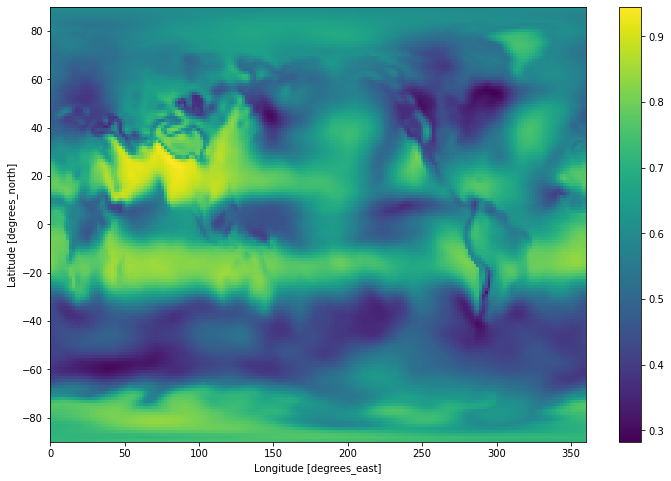

In [18]:
corr.plot(figsize=(12, 8))

### Close the client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [19]:
client.close()

## Reference

https://examples.dask.org/xarray.html